In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.utils.data as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root = './Data', train=True, download=True,transform=transform)
test_data = datasets.MNIST(root = './Data', train=False, download=True,transform=transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [21]:
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)  # input: 1 channel (grayscale), output: 6 channels
        self.conv2 = nn.Conv2d(6, 16, 3, 1)  # input: 6 channels, output: 16 channels
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = f.relu(self.conv1(x))  # Apply ReLU after first convolution
        x = f.max_pool2d(x, 2, 2)  # Apply max pooling
        x = f.relu(self.conv2(x))  # Apply ReLU after second convolution
        x = f.max_pool2d(x, 2, 2)  # Apply max pooling
        x = x.view(-1, 16 * 5 * 5)  # Flatten for fully connected layer
        x = f.relu(self.fc1(x))  # First fully connected layer
        x = f.relu(self.fc2(x))  # Second fully connected layer
        x = self.fc3(x)  # Output layer
        return f.log_softmax(x, dim=1)  # Log Softmax for output

In [30]:
torch.manual_seed(42)
model = ConvolutionNetwork()
model

ConvolutionNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
# Training loop
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Training
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        y_pred = model(X_train)  # Forward pass
        loss = criterion(y_pred, y_train)  # Calculate loss
        
        prediction = torch.max(y_pred.data, 1)[1]  # Get predictions
        batch_corr = (prediction == y_train).sum()  # Count correct predictions
        trn_corr += batch_corr  # Accumulate correct predictions
        
        optimizer.zero_grad()  # Zero gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        if b % 600 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {loss.item()}")

    train_losses.append(loss.item())  # Track loss
    test_losses.append(tst_corr)
    train_correct.append(trn_corr.item())  # Track correct predictions

    # Validation
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)  # Forward pass
            predicted = torch.max(y_val.data, 1)[1]  # Get predictions
            tst_corr += (predicted == y_test).sum()  # Count correct predictions

current_time = time.time()
total_time = (current_time - start_time) / 60
print(f"Training completed in {total_time:.2f} minutes")

model_path = "mnist_model.pth"
torch.save(model.state_dict(), model_path)


Epoch: 0 Batch: 600 Loss: 0.0006739984964951873
Epoch: 0 Batch: 1200 Loss: 0.008998407050967216
Epoch: 0 Batch: 1800 Loss: 0.01400483213365078
Epoch: 0 Batch: 2400 Loss: 0.0008749201660975814
Epoch: 0 Batch: 3000 Loss: 0.00018085818737745285
Epoch: 0 Batch: 3600 Loss: 5.590880846284563e-06
Epoch: 0 Batch: 4200 Loss: 0.10587972402572632
Epoch: 0 Batch: 4800 Loss: 0.06285103410482407
Epoch: 0 Batch: 5400 Loss: 0.0012491137022152543
Epoch: 0 Batch: 6000 Loss: 0.0025069869589060545
Epoch: 1 Batch: 600 Loss: 0.0004299763240851462
Epoch: 1 Batch: 1200 Loss: 1.814203460526187e-05
Epoch: 1 Batch: 1800 Loss: 6.435294926632196e-05
Epoch: 1 Batch: 2400 Loss: 0.01580653339624405
Epoch: 1 Batch: 3000 Loss: 9.042116289492697e-05
Epoch: 1 Batch: 3600 Loss: 0.000557052087970078
Epoch: 1 Batch: 4200 Loss: 0.013021165505051613
Epoch: 1 Batch: 4800 Loss: 0.0003997675667051226
Epoch: 1 Batch: 5400 Loss: 8.621536835562438e-05
Epoch: 1 Batch: 6000 Loss: 0.0020982970017939806
Epoch: 2 Batch: 600 Loss: 0.0019

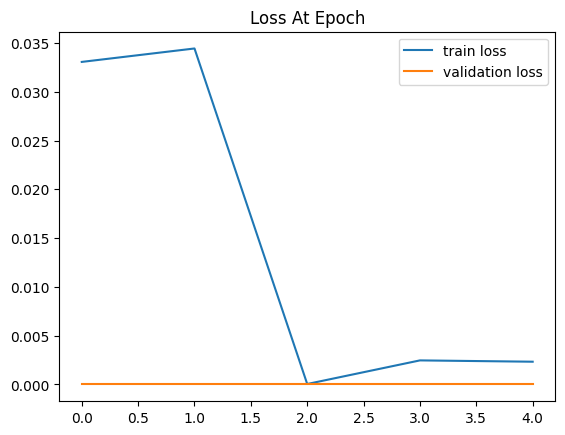

In [34]:
plt.plot(train_losses, label = "train loss")
plt.plot(test_losses, label = "validation loss")
plt.title('Loss At Epoch')
plt.legend()

In [39]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [40]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [42]:
correct.item() / len(test_data)

0.9878

In [43]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}' ))
print(np.arange(10).reshape(1,10))
print()

print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 971    0    1    0    0    2    3    1    4    1]
 [   0 1130    1    0    0    0    1    3    0    0]
 [   4    1 1026    1    0    0    1    7    1    0]
 [   0    2    0 1004    0   23    0    0    2    5]
 [   0    0    1    0  978    0    1    2    1    7]
 [   0    0    0    0    0  861    1    0    0    3]
 [   4    2    0    0    1    3  950    0    0    1]
 [   1    0    2    1    0    1    0 1009    0    4]
 [   0    0    1    4    1    1    1    2  965    4]
 [   0    0    0    0    2    1    0    4    1  984]]


In [45]:
model.eval()

ConvolutionNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)